⚙️ Using device: cuda
📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv
✅ Sequence shape: (939, 60, 18), Target: (939, 1)
📊 Train: 751, Val: 93, Test: 95
CNN_LSTM_Regressor(
  (conv1): Conv1d(18, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
Epoch [1/35] | Train Loss: 0.93355 | Val Loss: 0.33629
Epoch [2/35] | Train Loss: 0.40598 | Val Loss: 0.06012
Epoch [3/35] | Train Loss: 0.20182 | Val Loss: 0.06816
Epoch [4/35] | Train Loss: 0.15315 | Val Loss: 0.06341
Epoch [5/35] | Train Loss: 0.11926 | Val Loss: 0.03560
Epoch [6/35] | Train Loss: 0.11423 | Val Loss: 0.14920
Epoch [7/3

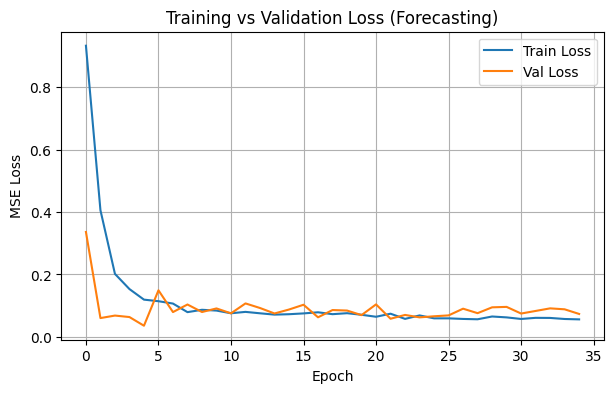

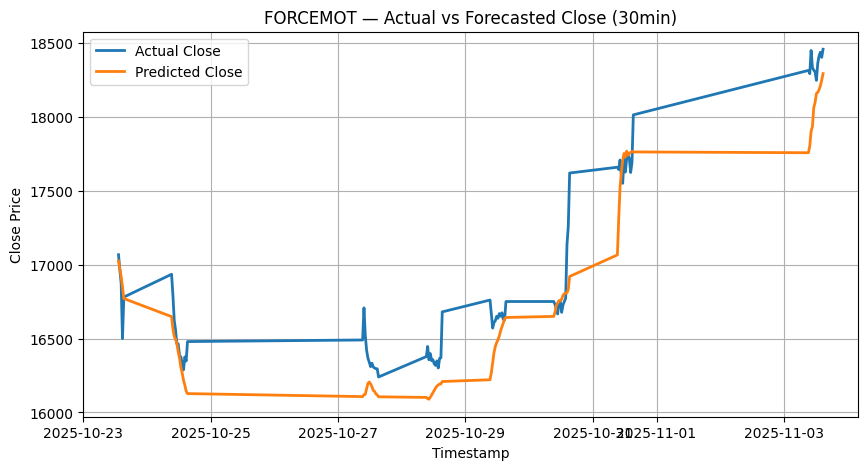

In [ ]:
# ============================================================
# 🧩 Quant Deep Model: CNN–LSTM Future Close Forecast (PyTorch)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
    
# ============================================================
# CONFIG
# ============================================================
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"
TIMEFRAME = "30min"
LOOKBACK = 60
EPOCHS = 35
BATCH_SIZE = 64
LR = 1e-3
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"⚙️ Using device: {DEVICE}")

np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================
# LOAD CSV
# ============================================================
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    latest = sorted(files)[-1]
    path = os.path.join(folder, latest)
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").reset_index(drop=True)
    return df

df = load_csv(STOCK_CODE, TIMEFRAME)

# ============================================================
# FEATURE & TARGET SETUP
# ============================================================
FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_Fast","MA_Slow","BB_Upper","BB_Lower",
    "MACD","MACD_Signal","MACD_Hist","+DI","-DI","ADX",
    "RSI14","ATR14","atr_pct"
]

df = df.dropna(subset=FEATURES).reset_index(drop=True)
df["target"] = df["Close"].shift(-1)   # next close price
df = df.dropna().reset_index(drop=True)

X_raw = df[FEATURES].values
y_raw = df["target"].values.reshape(-1, 1)

# ============================================================
# NORMALIZATION
# ============================================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# ============================================================
# SEQUENCE CREATION
# ============================================================
def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y_scaled, LOOKBACK)
timestamps = df["Timestamp"].values[LOOKBACK:]

print(f"✅ Sequence shape: {X_seq.shape}, Target: {y_seq.shape}")

# ============================================================
# TRAIN / VAL / TEST SPLIT (chronological)
# ============================================================
n_total = len(X_seq)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

X_train, X_val, X_test = X_seq[:n_train], X_seq[n_train:n_train+n_val], X_seq[n_train+n_val:]
y_train, y_val, y_test = y_seq[:n_train], y_seq[n_train:n_train+n_val], y_seq[n_train+n_val:]
ts_test = timestamps[n_train+n_val:]

print(f"📊 Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ============================================================
# DATASET / DATALOADER
# ============================================================
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(SeqDataset(X_val, y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(SeqDataset(X_test, y_test), batch_size=1, shuffle=False)

# ============================================================
# MODEL DEFINITION
# ============================================================
class CNN_LSTM_Regressor(nn.Module):
    def __init__(self, n_features, hidden_dim=64, lstm_units=64, dense_dim=32):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc1 = nn.Linear(lstm_units, dense_dim)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(dense_dim, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)           # (batch, features, seq)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = x.permute(0, 2, 1)           # (batch, seq/2, hidden)
        _, (h, _) = self.lstm(x)
        h = h[-1]
        x = torch.relu(self.fc1(h))
        x = self.drop(x)
        out = self.fc2(x)
        return out

model = CNN_LSTM_Regressor(n_features=X_seq.shape[2]).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
print(model)

# ============================================================
# TRAINING LOOP
# ============================================================
def train_model(model, train_loader, val_loader, epochs=EPOCHS):
    best_val = np.inf
    train_losses, val_losses = [], []
    for ep in range(epochs):
        model.train()
        run_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        train_loss = run_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                pred = model(Xb)
                loss = criterion(pred, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch [{ep+1}/{epochs}] | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_cnn_lstm_forecast.pt")

    model.load_state_dict(torch.load("best_cnn_lstm_forecast.pt"))
    print("✅ Training complete.")
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, EPOCHS)

# ============================================================
# EVALUATION
# ============================================================
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        pred = model(Xb).cpu().numpy().flatten()[0]
        preds.append(pred)
        trues.append(yb.numpy().flatten()[0])

# inverse-scale
preds_inv = scaler_y.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
trues_inv = scaler_y.inverse_transform(np.array(trues).reshape(-1,1)).flatten()

mae = mean_absolute_error(trues_inv, preds_inv)
rmse = np.sqrt(mean_squared_error(trues_inv, preds_inv))
direction_acc = np.mean(np.sign(np.diff(trues_inv)) == np.sign(np.diff(preds_inv)))

print("\n📈 Forecast Performance on Test Set")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"Directional Accuracy : {direction_acc:.4f}")

# ============================================================
# LOSS CURVES
# ============================================================
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss (Forecasting)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# FINAL PREDICTION PLOT
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(ts_test, trues_inv, label="Actual Close", linewidth=2)
plt.plot(ts_test, preds_inv, label="Predicted Close", linewidth=2)
plt.title(f"{STOCK_CODE} — Actual vs Forecasted Close ({TIMEFRAME})")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


⚙️ Using device: cuda
📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv
✅ Sequence shape: (939, 60, 18), Target: (939, 1)
📊 Train: 751, Val: 93, Test: 95
CNN_LSTM_Regressor(
  (conv1): Conv1d(18, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
Epoch [1/35] | Train Loss: 0.057520 | Val Loss: 0.011455
Epoch [2/35] | Train Loss: 0.014499 | Val Loss: 0.008378
Epoch [3/35] | Train Loss: 0.011040 | Val Loss: 0.003533
Epoch [4/35] | Train Loss: 0.008199 | Val Loss: 0.001464
Epoch [5/35] | Train Loss: 0.007344 | Val Loss: 0.000978
Epoch [6/35] | Train Loss: 0.007988 | Val Loss: 0.00057

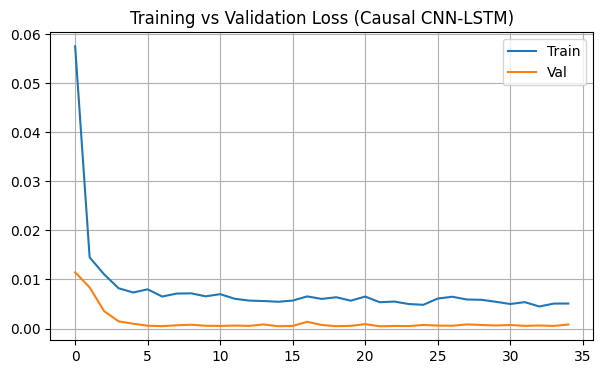

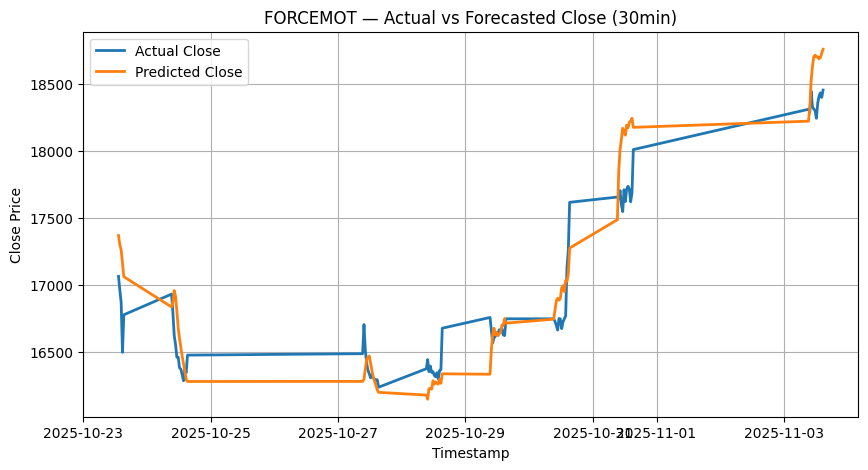

In [12]:
# ============================================================
# 🧩 Quant Deep Model: CNN–LSTM Future Close Forecast (Causal Safe)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ============================================================
# CONFIG
# ============================================================
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"
TIMEFRAME = "30min"
LOOKBACK = 60
EPOCHS = 35
BATCH_SIZE = 64
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"⚙️ Using device: {DEVICE}")

# ============================================================
# LOAD CSV
# ============================================================
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    latest = sorted(files)[-1]
    path = os.path.join(folder, latest)
    print(f"📂 Loading {path}")
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").reset_index(drop=True)
    return df

df = load_csv(STOCK_CODE, TIMEFRAME)

# ============================================================
# FEATURES & TARGET
# ============================================================
FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_Fast","MA_Slow","BB_Upper","BB_Lower",
    "MACD","MACD_Signal","MACD_Hist","+DI","-DI","ADX",
    "RSI14","ATR14","atr_pct"
]

df = df.dropna(subset=FEATURES).reset_index(drop=True)
df["target"] = df["Close"].shift(-1)
df = df.dropna().reset_index(drop=True)

X_raw = df[FEATURES].values
y_raw = df["target"].values.reshape(-1, 1)

# ============================================================
# NORMALIZATION
# ============================================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# ============================================================
# SEQUENCE CREATION
# ============================================================
def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y_scaled, LOOKBACK)
timestamps = df["Timestamp"].values[LOOKBACK:]

print(f"✅ Sequence shape: {X_seq.shape}, Target: {y_seq.shape}")

# ============================================================
# SPLIT (chronological)
# ============================================================
n_total = len(X_seq)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

X_train, X_val, X_test = X_seq[:n_train], X_seq[n_train:n_train+n_val], X_seq[n_train+n_val:]
y_train, y_val, y_test = y_seq[:n_train], y_seq[n_train:n_train+n_val], y_seq[n_train+n_val:]
ts_test = timestamps[n_train+n_val:]

print(f"📊 Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ============================================================
# DATASET / DATALOADER
# ============================================================
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(SeqDataset(X_val, y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(SeqDataset(X_test, y_test), batch_size=1, shuffle=False)

# ============================================================
# MODEL
# ============================================================
class CNN_LSTM_Regressor(nn.Module):
    def __init__(self, n_features, hidden_dim=64, lstm_units=64, dense_dim=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_features, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.fc1 = nn.Linear(lstm_units, dense_dim)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(dense_dim, 1)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = x.permute(0,2,1)
        _, (h, _) = self.lstm(x)
        x = torch.relu(self.fc1(h[-1]))
        x = self.drop(x)
        return self.fc2(x)

model = CNN_LSTM_Regressor(n_features=X_seq.shape[2]).to(DEVICE)
criterion = nn.SmoothL1Loss(beta=1.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
print(model)

# ============================================================
# TRAIN
# ============================================================
def train_model(model, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    for ep in range(epochs):
        model.train()
        total_train = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_train += loss.item()
        train_loss = total_train / len(train_loader)

        model.eval()
        total_val = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                pred = model(Xb)
                loss = criterion(pred, yb)
                total_val += loss.item()
        val_loss = total_val / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch [{ep+1}/{epochs}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, EPOCHS)

# ============================================================
# EVALUATION
# ============================================================
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        pred = model(Xb).cpu().numpy().flatten()[0]
        preds.append(pred)
        trues.append(yb.numpy().flatten()[0])

preds_inv = scaler_y.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
trues_inv = scaler_y.inverse_transform(np.array(trues).reshape(-1,1)).flatten()

mae = mean_absolute_error(trues_inv, preds_inv)
rmse = np.sqrt(mean_squared_error(trues_inv, preds_inv))
r2 = r2_score(trues_inv, preds_inv)
direction_acc = np.mean(np.sign(np.diff(trues_inv)) == np.sign(np.diff(preds_inv)))

print("\n📈 Forecast Performance on Test Set")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")
print(f"Directional Accuracy : {direction_acc:.4f}")

# ============================================================
# LOSS CURVE
# ============================================================
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Training vs Validation Loss (Causal CNN-LSTM)")
plt.legend(); plt.grid(True); plt.show()

# ============================================================
# PREDICTION PLOT
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(ts_test, trues_inv, label="Actual Close", linewidth=2)
plt.plot(ts_test, preds_inv, label="Predicted Close", linewidth=2)
plt.title(f"{STOCK_CODE} — Actual vs Forecasted Close ({TIMEFRAME})")
plt.xlabel("Timestamp"); plt.ylabel("Close Price")
plt.legend(); plt.grid(True); plt.show()


In [ ]:
# ============================================================
# 🧩 Multi-step CNN–LSTM Forecast — Interactive Plotly (gap-free index axis)
# ✅ Collapses overnight gaps, date-only ticks, hover shows 30-min timestamps
# ============================================================

import os, json
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.graph_objects as go

# ---------------------- CONFIG ----------------------
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"
TIMEFRAME = "45min"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESULT_FILE = "ztimeseries_v6_full_results.json"
MODEL_FILE = "models/multistep_cnn_lstm_best.pt"
os.makedirs("models", exist_ok=True)

LOOKBACK = 50
FORECAST_HORIZON = 26
BATCH_SIZE = 64
EPOCHS = 40
LR = 1e-3

print(f"⚙️ Using device: {DEVICE}")
print(f"Forecast horizon: {FORECAST_HORIZON} bars ({FORECAST_HORIZON*30/60:.1f} hours)")

# ---------------------- LOAD DATA ----------------------
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        raise FileNotFoundError(f"No CSV found for {stock_code}")
    path = os.path.join(folder, sorted(files)[-1])
    print("📂 Loading", path)
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").reset_index(drop=True)
    return df

df = load_csv(STOCK_CODE, TIMEFRAME)

FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_Fast","MA_Slow","BB_Upper","BB_Lower",
    "MACD","MACD_Signal","MACD_Hist","+DI","-DI","ADX",
    "RSI14","ATR14","atr_pct"
]
df = df.dropna(subset=FEATURES).reset_index(drop=True)

# ---------------------- PREP & SEQUENCES ----------------------
H = FORECAST_HORIZON
closes = df["Close"].values.reshape(-1,1)
X_raw = df[FEATURES].values
y_raw = closes.copy()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

def make_sequences_multi(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i:i+horizon].flatten())
    return np.array(Xs), np.array(ys)

X_seq, Y_seq = make_sequences_multi(X_scaled, y_scaled, LOOKBACK, H)
# sequence-aligned timestamps (start of each target window)
seq_timestamps = df["Timestamp"].values[LOOKBACK: len(X_seq) + LOOKBACK]

# ---------------------- SPLIT ----------------------
n_total = len(X_seq)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

X_train, X_val, X_test = X_seq[:n_train], X_seq[n_train:n_train+n_val], X_seq[n_train+n_val:]
Y_train, Y_val, Y_test = Y_seq[:n_train], Y_seq[n_train:n_train+n_val], Y_seq[n_train+n_val:]
ts_test = seq_timestamps[n_train + n_val:]   # timestamps aligned with each test sample
print(f"📊 Split → Train:{len(X_train)}, Val:{len(X_val)}, Test:{len(X_test)}")

# ---------------------- DATALOADERS ----------------------
class SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

train_loader = DataLoader(SeqDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(SeqDataset(X_val, Y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(SeqDataset(X_test, Y_test), batch_size=1)

# ---------------------- MODEL ----------------------
class CNN_LSTM_Multi(nn.Module):
    def __init__(self, n_features, hidden_dim=32, lstm_units=32, dense_dim=16, horizon=1, pool='max', dropout=0.35):
        super().__init__()
        self.conv1 = nn.Conv1d(n_features, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.pool = nn.MaxPool1d(2) if pool=='max' else nn.AvgPool1d(2)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc1 = nn.Linear(lstm_units, dense_dim)
        self.drop = nn.Dropout(dropout)
        self.fc_out = nn.Linear(dense_dim, horizon)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = x.permute(0,2,1)
        _, (h, _) = self.lstm(x)
        h = h[-1]
        x = torch.relu(self.fc1(h))
        x = self.drop(x)
        return self.fc_out(x)

n_feats = X_seq.shape[2]
model = CNN_LSTM_Multi(n_feats, 32, 32, 16, H, 'max', 0.35).to(DEVICE)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ---------------------- TRAIN ----------------------
def train_epoch():
    model.train()
    total = 0.0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, Yb)
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(train_loader)

def eval_epoch(loader):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for Xb, Yb in loader:
            Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
            out = model(Xb)
            loss = criterion(out, Yb)
            total += loss.item()
    return total / len(loader)

train_losses, val_losses = [], []
for ep in range(1, EPOCHS + 1):
    tr = train_epoch()
    va = eval_epoch(val_loader)
    scheduler.step()
    train_losses.append(tr); val_losses.append(va)
    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep}/{EPOCHS} | TrainLoss:{tr:.6f} | ValLoss:{va:.6f}")

torch.save(model.state_dict(), MODEL_FILE)

# ---------------------- PREDICT & INVERSE ----------------------
def inverse_scale(y_norm):
    n = y_norm.shape[0]
    flat = y_norm.reshape(-1,1)
    inv = scaler_y.inverse_transform(flat).reshape(n,-1)
    return inv

def predict(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, Yb in loader:
            Xb = Xb.to(DEVICE)
            out = model(Xb).cpu().numpy()
            preds.append(out); trues.append(Yb.numpy())
    return np.vstack(preds), np.vstack(trues)

test_pred_norm, test_true_norm = predict(test_loader)
test_pred = inverse_scale(test_pred_norm)
test_true = inverse_scale(test_true_norm)

# ---------------------- METRICS / DIRECTION ----------------------
test_start_idx = np.arange(n_train + n_val, n_train + n_val + len(X_test))  # sequence start indices into df
prev_idx = test_start_idx + LOOKBACK - 1
prev_closes = closes[prev_idx].flatten()[:len(test_pred)]

pred_dir = np.sign(test_pred[:,0] - prev_closes)
true_dir = np.sign(test_true[:,0] - prev_closes)
diracc_h0 = np.mean(pred_dir == true_dir)

diracc_all = [diracc_h0]
for h in range(1, H):
    td = test_true[:, h] - test_true[:, h-1]
    pd = test_pred[:, h] - test_pred[:, h-1]
    diracc_all.append(np.mean(np.sign(td) == np.sign(pd)))

mae_list = [mean_absolute_error(test_true[:, h], test_pred[:, h]) for h in range(H)]
rmse_list = [np.sqrt(mean_squared_error(test_true[:, h], test_pred[:, h])) for h in range(H)]
r2_list = [r2_score(test_true[:, h], test_pred[:, h]) for h in range(H)]

best_h = int(np.argmax(diracc_all))
best_acc = float(diracc_all[best_h])

# ---------------------- SAVE RESULTS ----------------------
results = {
    "Config": {"lookback": LOOKBACK, "horizon": H, "lr": LR},
    "Metrics": {
        "DirAcc_all": [float(x) for x in diracc_all],
        "MAE_all": mae_list, "RMSE_all": rmse_list, "R2_all": r2_list,
        "Best_Horizon": best_h, "Best_DirAcc": round(best_acc, 4)
    },
    "Loss": {"Train": train_losses, "Val": val_losses}
}
with open(RESULT_FILE, "w") as f:
    json.dump(results, f, indent=2)

# ---------------------- PREP INDEXED AXIS + HOVER TEXT ----------------------
# We'll map every df timestamp to a numeric index (0..N-1) so the plot is gap-free.
df_idx = np.arange(len(df))
# build hovertext for df points (full timestamp with time)
hover_full = [ts.strftime("%Y-%m-%d %H:%M") for ts in df["Timestamp"]]

# For test region, create index positions and hovertexts corresponding to seq starts
# test_start_indices point to the row index in df where each test sequence target begins
test_start_indices = test_start_idx  # these are indices in df corresponding to sequence start
# Make forecast_times labels (list of timestamps for each test sample, horizon point = best_h)
# For plotting aggregated series we will use the sequence start index + best_h as index where the value at horizon best_h belongs.
test_point_indices = test_start_indices + best_h  # index in df corresponding to the sample's best_h target
# ensure within df range
test_point_indices = test_point_indices[:len(test_pred)]

# Hover labels for test points (with 30-min time)
# Hover labels for test points (with 30-min time)
hover_test = [df["Timestamp"].iloc[int(i)].strftime("%Y-%m-%d %H:%M") for i in test_point_indices]

# ---------------------- PLOTLY: Forecast plot (test region only) ----------------------
# x axis will be the test_point_indices (numeric) but we show hover timestamps
x_test = test_point_indices
y_true_best = test_true[:, best_h]
y_pred_best = test_pred[:, best_h]

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=x_test, y=y_true_best, mode="lines+markers", name="Actual Close",
    text=hover_test, hovertemplate="%{text}<br>Actual: %{y:.2f}<extra></extra>"
))
fig1.add_trace(go.Scatter(
    x=x_test, y=y_pred_best, mode="lines+markers", name="Predicted Close",
    text=hover_test, hovertemplate="%{text}<br>Pred: %{y:.2f}<extra></extra>"
))
fig1.update_layout(
    title=f"{STOCK_CODE} — Best Horizon (h={best_h}) | DirAcc={best_acc:.3f}",
    xaxis_title="Index (gap-free)", yaxis_title="Close Price",
    hovermode="x unified"
)
# set x ticks to show date-only labels at reasonable intervals
n_ticks = 8
tick_pos = np.linspace(x_test[0], x_test[-1], n_ticks).astype(int)
tick_text = [df["Timestamp"].iloc[int(p)].strftime("%Y-%m-%d") for p in tick_pos]
fig1.update_xaxes(tickmode="array", tickvals=tick_pos.tolist(), ticktext=tick_text)
fig1.show()

# ---------------------- FIXED PLOTTING BLOCK (paste & replace) ----------------------
import plotly.graph_objects as go
df_idx = np.arange(len(df))
hover_full = [ts.strftime("%Y-%m-%d %H:%M") for ts in df["Timestamp"]]

# ---- Compute seq start indices in the dataframe for each sequence sample ----
# X_seq[0] corresponds to df index = LOOKBACK
# Index-of-sequence k (0-based) maps to df index = LOOKBACK + k
# Test sequences occupy k = n_train + n_val ... n_train + n_val + len(X_test)-1
seq_k_start = np.arange(n_train + n_val, n_train + n_val + len(X_test))  # k indices into X_seq
seq_df_start = LOOKBACK + seq_k_start  # corresponding df-row indices for each test sequence

# ---- For horizon best_h, the target Y value for a sequence at seq_df_start[k] is at df index (seq_df_start[k] + best_h) ----
plot_indices = seq_df_start + best_h
plot_indices = np.clip(plot_indices, 0, len(df)-1)  # safety

# Values to plot
y_true_best = test_true[:, best_h]   # actual close at horizon best_h
y_pred_best = test_pred[:, best_h]   # predicted close at horizon best_h

# ---- Build Figure ----
fig2 = go.Figure()

# Full historical series (gap-collapsed numeric x)
fig2.add_trace(go.Scatter(
    x=df_idx, y=df["Close"], mode="lines", name="Historical Close",
    line=dict(color="gray", width=1.2),
    hovertext=hover_full, hovertemplate="%{hovertext}<br>Close: %{y:.2f}<extra></extra>"
))

# Actual closes at horizon (plotted at df index = seq_df_start + best_h)
fig2.add_trace(go.Scatter(
    x=plot_indices,
    y=y_true_best,
    mode="lines+markers",
    name="Actual Close (Test region)",
    line=dict(color="blue", width=3),
    opacity=0.95,
    hovertext=[df['Timestamp'].iloc[int(i)].strftime("%Y-%m-%d %H:%M") for i in plot_indices],
    hovertemplate="%{hovertext}<br>Actual: %{y:.2f}<extra></extra>"
))

# Predictions placed at the same future timestamps (seq_df_start + best_h)
fig2.add_trace(go.Scatter(
    x=plot_indices,
    y=y_pred_best,
    mode="lines+markers",
    name="Predicted Close (Forecast)",
    line=dict(color="orange", width=2, dash="dash"),
    hovertext=[df['Timestamp'].iloc[int(i)].strftime("%Y-%m-%d %H:%M") for i in plot_indices],
    hovertemplate="%{hovertext}<br>Predicted: %{y:.2f}<extra></extra>"
))

# Forecast start vertical line (where first test sequence's input window ends)
forecast_start_index = seq_df_start[0]   # first test sequence corresponds to this df row as its Y[0]
fig2.add_vline(x=forecast_start_index, line=dict(color="red", dash="dot", width=2))
fig2.add_annotation(
    x=forecast_start_index,
    y=max(df["Close"]),
    text="Forecast Start",
    showarrow=False,
    font=dict(color="red", size=12),
    yanchor="bottom"
)

# Layout ticks
n_ticks = 12
tick_positions = np.linspace(0, len(df_idx)-1, n_ticks).astype(int)
tick_labels = [df["Timestamp"].iloc[i].strftime("%Y-%m-%d") for i in tick_positions]

fig2.update_layout(
    title=f"{STOCK_CODE} — Historical + Forecast Region<br>"
          f"Best Horizon = h{best_h} ({best_h*30} min ahead) | DirAcc = {best_acc:.3f}",
    xaxis_title="Date (collapsed gaps)",
    yaxis_title="Close Price",
    hovermode="x unified",
    xaxis=dict(tickmode="array", tickvals=tick_positions, ticktext=tick_labels, rangeslider_visible=True),
    legend=dict(bgcolor="rgba(255,255,255,0.6)", bordercolor="gray")
)

fig2.show()
# ---------------------- END FIXED PLOTTING BLOCK ----------------------


# ---------------------- FINAL PRINT & SAVE ----------------------
print("\n✅ Best Directional Accuracy Summary:")
print(json.dumps({
    "Best_Horizon": best_h,
    "DirAcc": round(best_acc, 4),
    "MAE": round(mae_list[best_h], 3),
    "RMSE": round(rmse_list[best_h], 3),
    "R2": round(r2_list[best_h], 4)
}, indent=2))
print(f"\n📁 Full results saved to: {RESULT_FILE}")


⚙️ Using device: cuda
Forecast horizon: 26 bars (13.0 hours)
📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv
📊 Split → Train:740, Val:92, Test:93
Epoch 1/40 | TrainLoss:0.134532 | ValLoss:0.043213
Epoch 5/40 | TrainLoss:0.080235 | ValLoss:0.021565
Epoch 10/40 | TrainLoss:0.036530 | ValLoss:0.007960
Epoch 15/40 | TrainLoss:0.027290 | ValLoss:0.005559
Epoch 20/40 | TrainLoss:0.021177 | ValLoss:0.004064
Epoch 25/40 | TrainLoss:0.016118 | ValLoss:0.003616
Epoch 30/40 | TrainLoss:0.016220 | ValLoss:0.003577
Epoch 35/40 | TrainLoss:0.015943 | ValLoss:0.003757
Epoch 40/40 | TrainLoss:0.015475 | ValLoss:0.003711



✅ Best Directional Accuracy Summary:
{
  "Best_Horizon": 2,
  "DirAcc": 0.6022,
  "MAE": 436.099,
  "RMSE": 497.574,
  "R2": -0.2756
}

📁 Full results saved to: ztimeseries_v6_full_results.json


In [7]:
# ============================================================
# 🧩 Multi-step CNN–LSTM Forecast — Grid Search + Best Plot
# ============================================================

import os, json, itertools, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from copy import deepcopy
import plotly.graph_objects as go

# ---------------------- CONFIG ----------------------
DATA_BASE_PATH = "history_data"
STOCK_CODE = "FORCEMOT"
TIMEFRAME = "30min"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

FORECAST_HORIZON = 26
BATCH_SIZE = 64
EPOCHS = 30
WEIGHT_DECAY = 1e-4

print(f"⚙️ Using device: {DEVICE}")

# ---------------------- LOAD DATA ----------------------
def load_csv(stock_code: str, tf: str):
    folder = os.path.join(DATA_BASE_PATH, f"history_data_{stock_code}")
    files = [f for f in os.listdir(folder) if tf in f and f.endswith(".csv")]
    if not files:
        raise FileNotFoundError(f"No CSV found for {stock_code}")
    path = os.path.join(folder, sorted(files)[-1])
    print("📂 Loading", path)
    df = pd.read_csv(path)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").reset_index(drop=True)
    return df

df = load_csv(STOCK_CODE, TIMEFRAME)

FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_Fast","MA_Slow","BB_Upper","BB_Lower",
    "MACD","MACD_Signal","MACD_Hist","+DI","-DI","ADX",
    "RSI14","ATR14","atr_pct"
]
df = df.dropna(subset=FEATURES).reset_index(drop=True)

H = FORECAST_HORIZON
closes = df["Close"].values.reshape(-1,1)
X_raw = df[FEATURES].values
y_raw = closes.copy()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

def make_sequences_multi(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i:i+horizon].flatten())
    return np.array(Xs), np.array(ys)

# ---------------------- MODEL ----------------------
class CNN_LSTM_Multi(nn.Module):
    def __init__(self, n_features, hidden_dim=32, lstm_units=32, dense_dim=16, horizon=1, pool='max', dropout=0.35):
        super().__init__()
        self.conv1 = nn.Conv1d(n_features, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.pool = nn.MaxPool1d(2) if pool=='max' else nn.AvgPool1d(2)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc1 = nn.Linear(lstm_units, dense_dim)
        self.drop = nn.Dropout(dropout)
        self.fc_out = nn.Linear(dense_dim, horizon)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = x.permute(0,2,1)
        _, (h, _) = self.lstm(x)
        h = h[-1]
        x = torch.relu(self.fc1(h))
        x = self.drop(x)
        return self.fc_out(x)

# ---------------------- HYPERPARAMETER GRID ----------------------
param_grid = {
    "LOOKBACK": [10, 20, 30, 40, 50, 60, 70, 80],
    "LR": [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
    "hidden_dim": [16, 32, 48, 64, 96, 128],
    "dropout": [0.15, 0.25, 0.35, 0.45],
}

param_combos = list(itertools.product(*param_grid.values()))
random.shuffle(param_combos)
print(f"🧮 Total hyperparameter configs: {len(param_combos)}")

results_summary = []
best_model_state = None
best_config = None
best_acc = -1
best_train_losses, best_val_losses = None, None
best_data = None

# ---------------------- MAIN LOOP ----------------------
for combo in param_combos:
    cfg = dict(zip(param_grid.keys(), combo))
    LOOKBACK, LR, hidden_dim, dropout = cfg["LOOKBACK"], cfg["LR"], cfg["hidden_dim"], cfg["dropout"]

    print(f"\n🚀 Training Config: {cfg}")

    # --- Prepare sequences ---
    X_seq, Y_seq = make_sequences_multi(X_scaled, y_scaled, LOOKBACK, H)
    n_total = len(X_seq)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    X_train, X_val, X_test = X_seq[:n_train], X_seq[n_train:n_train+n_val], X_seq[n_train+n_val:]
    Y_train, Y_val, Y_test = Y_seq[:n_train], Y_seq[n_train:n_train+n_val], Y_seq[n_train+n_val:]

    class SeqDataset(Dataset):
        def __init__(self, X, Y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.Y = torch.tensor(Y, dtype=torch.float32)
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.Y[idx]

    train_loader = DataLoader(SeqDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(SeqDataset(X_val, Y_val), batch_size=BATCH_SIZE)
    test_loader = DataLoader(SeqDataset(X_test, Y_test), batch_size=1)

    n_feats = X_seq.shape[2]
    model = CNN_LSTM_Multi(n_feats, hidden_dim, hidden_dim, hidden_dim//2, H, 'max', dropout).to(DEVICE)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_losses, val_losses = [], []
    best_val = float("inf")

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss = 0.0
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, Yb)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()
        tr_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
                out = model(Xb)
                loss = criterion(out, Yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        scheduler.step()

        train_losses.append(tr_loss)
        val_losses.append(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            best_state = deepcopy(model.state_dict())

        if ep % 5 == 0 or ep == 1:
            print(f"Epoch {ep}/{EPOCHS} | Train:{tr_loss:.5f} | Val:{val_loss:.5f}")

    # --- Evaluate on test ---
    model.load_state_dict(best_state)
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, Yb in test_loader:
            Xb = Xb.to(DEVICE)
            out = model(Xb).cpu().numpy()
            preds.append(out)
            trues.append(Yb.numpy())

    test_pred = np.vstack(preds)
    test_true = np.vstack(trues)
    test_pred = scaler_y.inverse_transform(test_pred.reshape(-1,1)).reshape(test_pred.shape)
    test_true = scaler_y.inverse_transform(test_true.reshape(-1,1)).reshape(test_true.shape)

    # Directional accuracy
    diracc_all = []
    for h in range(H):
        td = test_true[:, h] - np.roll(test_true[:, h], 1)
        pd = test_pred[:, h] - np.roll(test_pred[:, h], 1)
        diracc_all.append(np.mean(np.sign(td[1:]) == np.sign(pd[1:])))
    best_h = int(np.argmax(diracc_all))
    diracc = float(diracc_all[best_h])

    mae = mean_absolute_error(test_true[:, best_h], test_pred[:, best_h])
    rmse = np.sqrt(mean_squared_error(test_true[:, best_h], test_pred[:, best_h]))
    r2 = r2_score(test_true[:, best_h], test_pred[:, best_h])

    result = {
        **cfg,
        "Best_Horizon": best_h,
        "DirAcc": round(diracc, 4),
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2": round(r2, 3),
        "ValLoss": round(best_val, 6)
    }
    results_summary.append(result)
    print("✅ Result:", result)

    # Save best model in memory
    if diracc > best_acc:
        best_acc = diracc
        best_model_state = deepcopy(best_state)
        best_config = cfg
        best_train_losses, best_val_losses = train_losses, val_losses
        best_data = (test_true, test_pred, best_h)

# ---------------------- SHOW BEST RESULT ----------------------
print("\n🏁 BEST MODEL CONFIG:")
print(best_config)

test_true, test_pred, best_h = best_data
y_true_best = test_true[:, best_h]
y_pred_best = test_pred[:, best_h]

# ---------------------- PLOTS ----------------------

# 1️⃣ Train vs Val Loss
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=best_train_losses, mode="lines+markers", name="Train Loss"))
fig_loss.add_trace(go.Scatter(y=best_val_losses, mode="lines+markers", name="Val Loss"))
fig_loss.update_layout(title="Training vs Validation Loss", xaxis_title="Epoch", yaxis_title="Loss")
fig_loss.show()

# 2️⃣ Actual vs Predicted
fig_pred = go.Figure()
fig_pred.add_trace(go.Scatter(y=y_true_best, mode="lines", name="Actual Close"))
fig_pred.add_trace(go.Scatter(y=y_pred_best, mode="lines", name="Predicted Close"))
fig_pred.update_layout(title=f"Best Model Forecast — Horizon h={best_h}", xaxis_title="Time Steps", yaxis_title="Close Price")
fig_pred.show()

# ---------------------- SAVE FINAL JSON ----------------------
final_result = {
    "Best_Config": best_config,
    "Metrics": {
        "DirAcc": round(best_acc, 4),
        "Best_Horizon": int(best_h),
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2": round(r2, 3)
    }
}
json.dump(final_result, open("best_result.json", "w"), indent=2)
print("\n📁 Final result saved to best_result.json")


⚙️ Using device: cuda
📂 Loading history_data\history_data_FORCEMOT\FORCEMOT_30min_2024-11-03_to_2025-11-03.csv
🧮 Total hyperparameter configs: 960

🚀 Training Config: {'LOOKBACK': 10, 'LR': 0.005, 'hidden_dim': 128, 'dropout': 0.25}
Epoch 1/30 | Train:0.06003 | Val:0.00502
Epoch 5/30 | Train:0.00667 | Val:0.00265
Epoch 10/30 | Train:0.00399 | Val:0.00236
Epoch 15/30 | Train:0.00348 | Val:0.00209
Epoch 20/30 | Train:0.00352 | Val:0.00251
Epoch 25/30 | Train:0.00314 | Val:0.00208
Epoch 30/30 | Train:0.00272 | Val:0.00255
✅ Result: {'LOOKBACK': 10, 'LR': 0.005, 'hidden_dim': 128, 'dropout': 0.25, 'Best_Horizon': 7, 'DirAcc': 0.5833, 'MAE': 541.972, 'RMSE': np.float64(724.041), 'R2': -1.425, 'ValLoss': 0.001885}

🚀 Training Config: {'LOOKBACK': 70, 'LR': 0.0001, 'hidden_dim': 96, 'dropout': 0.25}
Epoch 1/30 | Train:0.13252 | Val:0.04565
Epoch 5/30 | Train:0.07942 | Val:0.01779
Epoch 10/30 | Train:0.03134 | Val:0.00448
Epoch 15/30 | Train:0.02503 | Val:0.00319
Epoch 20/30 | Train:0.02211 | 


📁 Final result saved to best_result.json
